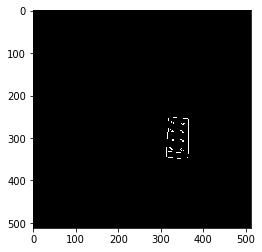

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import sys
import math
import json
import re

sys.path.append("/Users/will/projects/legoproj")

import utils.feature_utils as fu
import utils.cv_utils as cvu


%matplotlib inline

fu.dim = 512

expr = re.compile("([-]?[0-9]*\.[0-9]{4})")


datadir = "/Users/will/Desktop/brick_oneofeach/"
img0 = cv2.imread('wing2.png',0)
img = cv2.imread(datadir + '2_brick_a.png')


gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = cv2.bilateralFilter(gray, 11, 17, 17)


edged = cv2.Canny(gray, 30, 200)
'''
cv2.imshow('Edges', edged)
if cv2.waitKey(0) & 0xff == 27:
   cv2.destroyAllWindows()
'''
plt.imshow(edged,cmap='gray')
plt.show()

kernel = np.ones((2,2), np.uint8) 
edged = cv2.dilate(edged, kernel, iterations=2) 


#cv2.imshow('Dilated', edged)

'''
if cv2.waitKey(0) & 0xff == 27:
   cv2.destroyAllWindows()
'''

contours, hierarchy = cv2.findContours(edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)


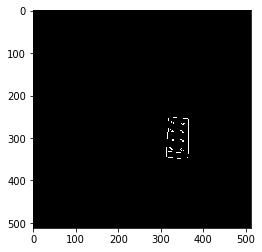

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import sys
import math
import json
import re

sys.path.append("/Users/will/projects/legoproj")

import utils.feature_utils as fu
import utils.cv_utils as cvu


%matplotlib inline

fu.dim = 512

expr = re.compile("([-]?[0-9]*\.[0-9]{4})")


datadir = "/Users/will/Desktop/brick_oneofeach/"
img0 = cv2.imread('wing2.png',0)
img = cv2.imread(datadir + '2_brick_a.png')


gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = cv2.bilateralFilter(gray, 11, 17, 17)


edged = cv2.Canny(gray, 30, 200)
'''
cv2.imshow('Edges', edged)
if cv2.waitKey(0) & 0xff == 27:
   cv2.destroyAllWindows()
'''
plt.imshow(edged,cmap='gray')
plt.show()

kernel = np.ones((2,2), np.uint8) 
edged = cv2.dilate(edged, kernel, iterations=2) 


#cv2.imshow('Dilated', edged)

'''
if cv2.waitKey(0) & 0xff == 27:
   cv2.destroyAllWindows()
'''

contours, hierarchy = cv2.findContours(edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)


[[-1.        -1.         0.       ]
 [ 1.        -1.         0.       ]
 [-1.         1.         0.       ]
 [ 1.         1.         0.       ]
 [ 0.        -1.3810458  0.       ]
 [ 0.         1.3810458  0.       ]
 [-1.8885571  0.         0.       ]
 [ 1.8885571  0.         0.       ]
 [ 0.         0.         0.       ]]
[[375 355]
 [355 175]
 [175 358]
 [175 162]
 [397 261]
 [135 253]
 [285 454]
 [264  97]
 [274 257]]
[[576.25736062   0.         248.52187915]
 [  0.         574.53464139 245.49564366]
 [  0.           0.           1.        ]]


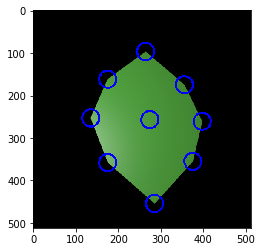

In [3]:
overts, sverts = fu.getCalibCorrs()
calibimg = cv2.imread("/Users/will/projects/legoproj/utils/calib_data/calib.png")

for vert in sverts:
    cv2.circle(calibimg, (vert[0], vert[1]), 20, (0, 0, 255), 3)

print(overts)
print(sverts)
    
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera([overts.astype('float32')], [sverts.astype('float32')], (512,512), None, None)

print(mtx)

plt.imshow(calibimg)
plt.show()

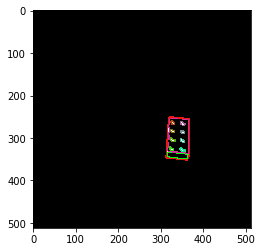

Found contour of length: 119.21320307254791
Found contour of length: 39.31370830535889
Found contour of length: 29.899494647979736
Found contour of length: 29.313708305358887
Found contour of length: 35.3137081861496
Found contour of length: 28.727921724319458
Found contour of length: 27.899494528770447
Found contour of length: 34.72792172431946
Found contour of length: 29.899494767189026
Found contour of length: 265.11269783973694
Found contour of length: 299.11269783973694


In [4]:
img1 = cv2.cvtColor(edged,cv2.COLOR_GRAY2RGB)

num = len(contours)

for i in range(num):
    one = math.floor(i/num * 255)
    other = 255 - one
    b = 150 if i % 2 else 20
    cv2.drawContours(img1, contours, i, (one, other, b), 2)

 
plt.imshow(img1)
plt.show()

for contour in contours:
    perimeter = cv2.arcLength(contour,True)
    print("Found contour of length: " + str(perimeter))

In [5]:
t = contours[-2]
t2 = contours[0]

In [6]:
approx = cv2.approxPolyDP(t,0.05*cv2.arcLength(t,True),True)
approx2 = cv2.approxPolyDP(t2,0.05*cv2.arcLength(t2,True),True)
approx2

array([[[315, 335]],

       [[364, 341]],

       [[360, 349]],

       [[320, 346]]], dtype=int32)

In [7]:
def get_pair(index, points):
    
    num = len(points)
    for i in range(num):
        j = i + 1 if i < num - 1 else 0
        
        if i == index:
            return np.array([points[i], points[j]])
    return None


def get_slopes(points):
    num = len(points)
    slopes = []
    
    for i in range(num):

        j = i + 1 if i < num - 1 else 0
        
        diff = points[j] - points[i]
        
        if diff[1] == 0:
            diff[1] += 1
            
        slope = diff[0]/diff[1]
        slopes.append(tuple([i, slope]))
    
    slopes.sort(key=lambda x: x[1])
    return slopes


def get_parallel_pair(slopes):
    
    num = len(slopes)
    
    for i in range(num):
        j = i + 1 if i < num - 1 else 0
        
        cur0 = slopes[0][1]
        cur1 = slopes[1][1]
        
        if abs(cur1 - cur0) < .5:
            return tuple([cur0[0], cur1[0]])
        
    return None
        
    
    
def edge_march(edge, studs):
    return None
    

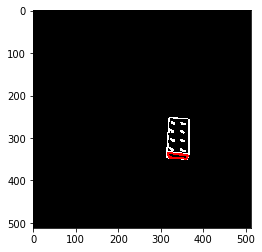

In [8]:
img2 = cv2.cvtColor(edged,cv2.COLOR_GRAY2RGB)
cv2.drawContours(img2, [approx2], 0, (255, 0, 0), 3)

plt.imshow(img2)
plt.show()

In [9]:
approx = np.reshape(approx, (-1,2))

slopes = get_slopes(approx)

approx2 = np.reshape(approx2, (-1,2))
slopes2 = get_slopes(approx2)
approx

array([[322, 253],
       [365, 258],
       [364, 336],
       [315, 329]], dtype=int32)

In [10]:
line = get_pair(1,approx)
print(line)

[[365 258]
 [364 336]]


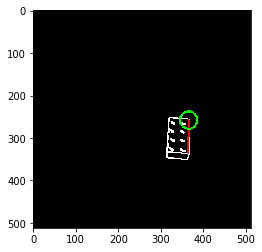

In [11]:
img2 = cv2.cvtColor(edged,cv2.COLOR_GRAY2RGB)
cv2.drawContours(img2, [line], 0, (255, 0, 0), 3)

cv2.circle(img2, (365, 258), 20, (0, 255, 0), 3)

plt.imshow(img2)
plt.show()

In [12]:
ocoordscw = np.array([(-0.64, -0.32, 0.0), (-0.64, 0.32, 0.0), (0.64, 0.32, 0.0),(0.64, 0.32, -0.384)], dtype = "float32")
#ocoordscw = np.array([(-0.64, 0, -0.32), (-0.64, 0, 0.32), (0.64, 0, 0.32), (0.64, 0, -0.32)], dtype = "double")
scoordscw = []

for t in approx[0:3]:
    scoordscw.append(tuple(t))

scoordscw.append(tuple([360, 349]))  
scoordscw = np.array(scoordscw, dtype = "double")

pmat = fu.get_object_matrices(datadir + "mats/{}.txt".format(2))["Projection"]

f = pmat[0][0]
pmat
#mtx[0][2] = 256
#mtx[1][2] = 256

array([[ 2.1875,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  2.1875,  0.    ,  0.    ],
       [ 0.    ,  0.    , -1.002 , -0.2002],
       [ 0.    ,  0.    , -1.    ,  0.    ]], dtype=float32)

In [13]:
cmat = np.array([  [f, 0, 256],  [0, f, 256], [0, 0, -1]  ], dtype = "double")

In [14]:
cmat
ocoordscw.shape

(4, 3)

In [15]:
dist_coeffs = np.zeros((4,1))
ocoordscw = np.reshape(ocoordscw, (4,1,3))
scoordscw = np.reshape(scoordscw, (4,1,2))
ocoordscw = ocoordscw.astype(np.float32)
scoordscw = scoordscw.astype(np.float32)

#ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(ocoordscw, scoordscw, (512, 512),None,None)
r = cv2.solvePnPRansac(ocoordscw, scoordscw, mtx, dist, flags=(cv2.SOLVEPNP_ITERATIVE))
#mat, jac = cv2.Rodrigues(r[1])
#mat.append([0.0,0.0,0.0,1])
r

(True, array([[ 1.76287171],
        [ 2.00963852],
        [-0.59269336]]), array([[1.34904367],
        [0.67589061],
        [8.36928889]]), array([[0],
        [1],
        [2],
        [3]], dtype=int32))

In [16]:
rvec = r[1]
tvec = r[2]
tvec

array([[1.34904367],
       [0.67589061],
       [8.36928889]])

In [17]:
(pt, jac) = cv2.projectPoints(np.array([(0,0.0,0.0),(1.0, 0.0, 0.0),(0.0, 1.0, 0.0),(0.0, 0.0, 1.0)]), rvec, tvec, mtx, dist)

In [18]:
pt = pt.astype(int)
pt

array([[[342, 292]],

       [[339, 357]],

       [[411, 300]],

       [[353, 254]]])

(342, 292)
(339, 357)
(411, 300)
(353, 254)


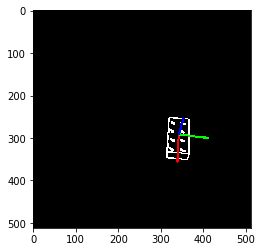

In [19]:
img3 = cv2.cvtColor(edged,cv2.COLOR_GRAY2RGB)
lines = [(255,0,0), (0,255,0), (0,0,255)]

print(tuple(pt[0][0]))

i = 0
for point in pt[1:4]:
    o = pt[0][0]
    print(tuple(point[0]))
    cv2.line(img3, tuple(o), tuple(point[0]), lines[i], 3)
    i+=1
    
plt.imshow(img3)
plt.show()

In [20]:
data = {}
name = "combo1"
file = "/Users/will/projects/legoproj/data/{}/{}.json".format(name,name)
img = "/Users/will/projects/legoproj/data/{}/{}.png".format(name,name)
img = cv2.imread(img)
with open(file) as json_file:
        data = json.load(json_file)
data["objects"]

{'Pole.001': {'diffuse': [0.10000000149011612,
   0.10000000149011612,
   0.10000000149011612],
  'modelmat': '<Matrix 4x4 (-0.0000, -1.0000, 0.0000, -0.5941)\n            ( 1.0000, -0.0000, 0.0000,  0.5007)\n            ( 0.0000,  0.0000, 1.0000,  0.8305)\n            ( 0.0000,  0.0000, 0.0000,  1.0000)>',
  'maskpath': '/Users/will/projects/legoproj/data/combo1/masks/Pole_001.png',
  'matname': 'Black.091'},
 'Brick.002': {'diffuse': [0.5, 0.5, 0.5],
  'modelmat': '<Matrix 4x4 ( 1.0000, 0.0010, 0.0000, -0.0278)\n            (-0.0010, 1.0000, 0.0000, -1.9706)\n            ( 0.0000, 0.0000, 1.0000,  0.4388)\n            ( 0.0000, 0.0000, 0.0000,  1.0000)>',
  'maskpath': '/Users/will/projects/legoproj/data/combo1/masks/Brick_002.png',
  'matname': 'Gray.091'},
 'WingR.001': {'diffuse': [0.800000011920929,
   0.800000011920929,
   0.800000011920929],
  'modelmat': '<Matrix 4x4 (1.0000, 0.0000, 0.0000,  0.0000)\n            (0.0000, 1.0000, 0.0000, -2.2571)\n            (0.0000, 0.0000, 

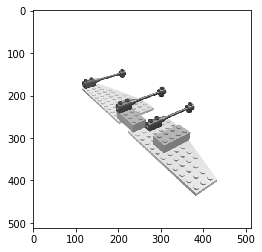

In [21]:
plt.imshow(img)
plt.show()

In [22]:
wingimg = cvu.showComboMask(img, data, "WingL")

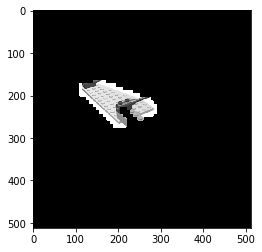

In [23]:
plt.imshow(wingimg)
plt.show()

(512, 512)


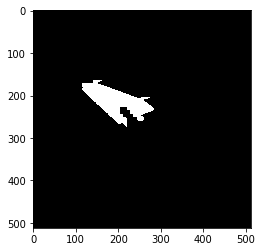

In [24]:
gray = cv2.cvtColor(wingimg,cv2.COLOR_BGR2GRAY)
print(gray.shape)

for i in range(512):
    for j in range(512):
        if gray[i][j] == 0:
            gray[i][j] = 255

status, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)
            
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)            

#dst = cv2.cornerHarris(gray,5,5,0.05)
#dst = cv2.dilate(dst,None)
# Threshold for an optimal value, it may vary depending on the image.
#img[dst>0.01*dst.max()]=[0,0,255]
#gray = cv2.bilateralFilter(gray, 11, 17, 17)
"""
edged = cv2.Canny(gray, 30, 100)


corners = cv2.goodFeaturesToTrack(gray,25,0.01,10)
corners = np.int0(corners)

for i in corners:
    x,y = i.ravel()
    cv2.circle(gray,(x,y),3,3,3)
"""


plt.imshow(thresh, cmap='gray')
plt.show()

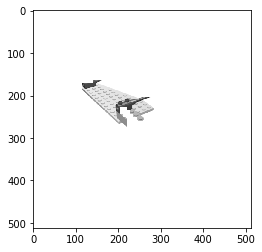

3

In [25]:
img1 = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)

num = len(contours)
bbox =None
for i in range(num):
    one = math.floor(i/num * 255)
    other = 255 - one
    #b = 150 if i % 2 else 20
    cur = contours[i]
    bbox = cv2.minAreaRect(cur)
    bbox = cv2.boxPoints(bbox)
    bbox = np.intp(bbox) #np.intp: Integer used for indexing (same as C ssize_t; normally either int32 or int64)
    #cv2.drawContours(drawing, [bbox], 0, color)
    #hull = cv2.convexHull(cur)
    #cv2.drawContours(img1, [bbox], 0, (one, other, 255), 2)

 
plt.imshow(img1)
plt.show()
num

In [26]:
bbox

array([[263, 289],
       [ 94, 228],
       [123, 149],
       [291, 210]])

In [27]:
img2 = cv2.cvtColor(img1,cv2.COLOR_BGR2HSV)

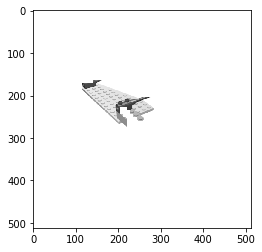

In [28]:
plt.imshow(img1, cmap="hsv")

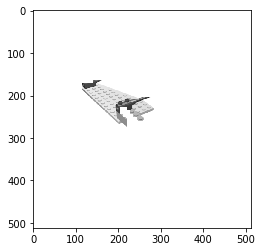

In [29]:
img5 = cv2.cvtColor(img2,cv2.COLOR_HSV2RGB)
gray2 = cv2.cvtColor(img5,cv2.COLOR_RGB2GRAY)

gray1 = cv2.bilateralFilter(gray2, 5, 500, 100)

plt.imshow(gray2, cmap="gray")
plt.show()
#edged = cv2.Canny(gray, 30, 200)

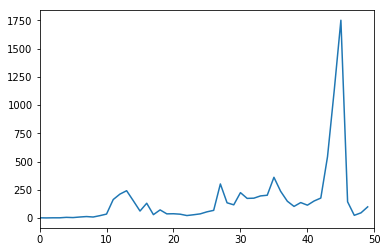

array([[1.000e+00],
       [0.000e+00],
       [1.000e+00],
       [1.000e+00],
       [5.000e+00],
       [3.000e+00],
       [8.000e+00],
       [1.200e+01],
       [8.000e+00],
       [2.000e+01],
       [3.400e+01],
       [1.630e+02],
       [2.110e+02],
       [2.410e+02],
       [1.520e+02],
       [6.100e+01],
       [1.300e+02],
       [2.900e+01],
       [7.100e+01],
       [3.600e+01],
       [3.700e+01],
       [3.300e+01],
       [2.100e+01],
       [2.800e+01],
       [3.600e+01],
       [5.400e+01],
       [6.700e+01],
       [3.010e+02],
       [1.340e+02],
       [1.160e+02],
       [2.240e+02],
       [1.730e+02],
       [1.750e+02],
       [1.950e+02],
       [2.010e+02],
       [3.600e+02],
       [2.360e+02],
       [1.480e+02],
       [1.020e+02],
       [1.360e+02],
       [1.130e+02],
       [1.500e+02],
       [1.760e+02],
       [5.420e+02],
       [1.127e+03],
       [1.752e+03],
       [1.430e+02],
       [2.300e+01],
       [4.500e+01],
       [9.800e+01]],

In [30]:
hist = cv2.calcHist([gray2],[0],None,[50],[0,254])

plt.plot(hist)
plt.xlim([0,50])
plt.show()

hist

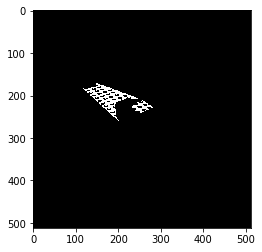

In [31]:
threshed = cv2.inRange(gray2, int(42/50 * 254), int(48/50 * 254))

threshed = cv2.bilateralFilter(threshed, 3, 900, 100)
threshed = cv2.inRange(threshed, 200,255)

kernel = np.ones((3,3),np.uint8)

#threshed = cv2.erode(threshed,kernel,iterations = 1)
#notted = cv2.bitwise_not(threshed)

#threshed = cv2.dilate(notted,kernel,iterations = 1)



plt.imshow(threshed, cmap="gray")
plt.show()

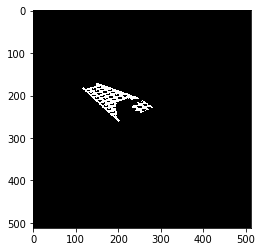

In [32]:
contours, hierarchy = cv2.findContours(threshed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


contours
length = 0
theone = None
for cnt in contours:
    cur = cv2.arcLength(cnt,True)
    if cur > length:
        length = cur
        theone = cnt

        
num = len(contours)
pres = cv2.cvtColor(threshed, cv2.COLOR_GRAY2RGB)

for i in range(num):
    one = math.floor(i/num * 255)
    other = 255 - one
    b = 150 if i % 2 else 20
    #cv2.drawContours(pres, contours, i, (one, other, b), 2)
        
#print(cnt)


cv2.drawContours(pres, [theone], 0, (255,255,255), 2)
plt.imshow(pres)
plt.show()

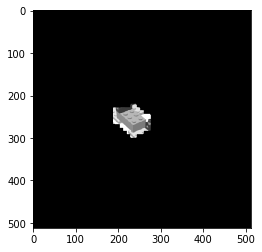

In [33]:
brickimg = cvu.showComboMask(img, data, "Brick.001")
brickimg = cv2.bilateralFilter(brickimg, 3, 900, 100)

plt.imshow(brickimg)
plt.show()

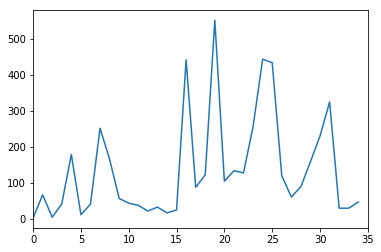

0,[3.]
1,[67.]
2,[5.]
3,[42.]
4,[179.]
5,[12.]
6,[41.]
7,[252.]
8,[166.]
9,[57.]
10,[44.]
11,[38.]
12,[22.]
13,[33.]
14,[17.]
15,[25.]
16,[442.]
17,[88.]
18,[123.]
19,[552.]
20,[105.]
21,[134.]
22,[128.]
23,[257.]
24,[444.]
25,[434.]
26,[120.]
27,[61.]
28,[90.]
29,[159.]
30,[231.]
31,[325.]
32,[30.]
33,[30.]
34,[47.]


In [34]:
brickgray = cv2.cvtColor(brickimg, cv2.COLOR_BGR2GRAY)

hist2 = cv2.calcHist([brickgray],[0],None,[35],[3,254])

plt.plot(hist2)
plt.xlim([0,35])
plt.show()

for i,bucket in enumerate(hist2):
    print("{},{}".format(i,bucket))

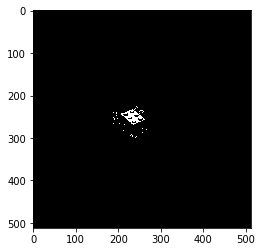

In [35]:
denom = 35
threshed2 = cv2.inRange(brickgray, int(24/denom * 254), int(26/denom * 254))

#threshed2 = cv2.bilateralFilter(threshed2, 5, 900, 100)
#threshed2 = cv2.bilateralFilter(threshed2, 3, 900, 100)
threshed2 = cv2.inRange(threshed2, 200,255)

contours, hierarchy = cv2.findContours(threshed2, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)




plt.imshow(threshed2, cmap="gray")
plt.show()

58


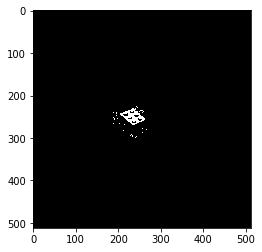

array([[[ 1, -1, -1, -1],
        [ 2,  0, -1, -1],
        [ 3,  1, -1, -1],
        [ 4,  2, -1, -1],
        [ 5,  3, -1, -1],
        [ 6,  4, -1, -1],
        [ 7,  5, -1, -1],
        [ 8,  6, -1, -1],
        [ 9,  7, -1, -1],
        [10,  8, -1, -1],
        [11,  9, -1, -1],
        [12, 10, -1, -1],
        [13, 11, -1, -1],
        [14, 12, -1, -1],
        [15, 13, -1, -1],
        [16, 14, -1, -1],
        [17, 15, -1, -1],
        [18, 16, -1, -1],
        [19, 17, -1, -1],
        [20, 18, -1, -1],
        [21, 19, -1, -1],
        [22, 20, -1, -1],
        [23, 21, -1, -1],
        [24, 22, -1, -1],
        [25, 23, -1, -1],
        [26, 24, -1, -1],
        [27, 25, -1, -1],
        [28, 26, -1, -1],
        [29, 27, -1, -1],
        [30, 28, -1, -1],
        [31, 29, -1, -1],
        [32, 30, -1, -1],
        [33, 31, -1, -1],
        [34, 32, -1, -1],
        [35, 33, -1, -1],
        [36, 34, -1, -1],
        [37, 35, -1, -1],
        [38, 36, -1, -1],
        [39,

In [36]:
contours, hierarchy = cv2.findContours(threshed2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contours
length = 0
theone = None
ind = 0
for i,cnt in enumerate(contours):
    cur = cv2.arcLength(cnt,True)
    if cur > length:
        length = cur
        theone = cnt
        ind = i
    
num = len(contours)
pres = cv2.cvtColor(threshed2, cv2.COLOR_GRAY2RGB)

for i in range(num):
    one = math.floor(i/num * 255)
    other = 255 - one
    b = 150 if i % 2 else 20
    #cv2.drawContours(pres, contours, i, (one, other, b), 2)
        
#print(cnt)
print(ind)

cv2.drawContours(pres, [theone], 0, (255,255,255), 2)
plt.imshow(pres)
plt.show()

theone

hierarchy